In [1]:
# Dependencies
import numpy as np
import pandas as pd
import tweepy
import time
import json
import matplotlib.pyplot as plt
import yaml

# Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Twitter API Keys
TWITTER_CONFIG_FILE = 'account2.yaml'

with open(TWITTER_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)

consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target Term
conversation_partner = "@VijayaTati"
my_username = "@VijayaTest2"

# crete a list to store tweet ids that were already analyzed
analyzed_tweet_ids = []

In [5]:

# Create function to return the target user and tweet id of recent tweet
def getTargetUserInfo():
    # Find the latest tweet with 2nd bot's username
    public_tweets = api.search(my_username, count=1, result_type="recent")
    for tweet in public_tweets["statuses"]:

        # Respond to the tweet with one of the response lines
        tweet_id = tweet["id"]
        tweet_text = tweet["text"]

        # get target user from the tweet
        tweet_words = tweet_text.split()
        target_user = tweet_words[-1]

        if tweet_id in analyzed_tweet_ids:
            print("Already Replied to the tweet")
            return "", ""
        else:         
            analyzed_tweet_ids.append(tweet_id)
            return target_user, tweet_id
    

In [6]:
def performVaderAnalysis(target_user):

    counter = 0
    # Variables for holding sentiments
    sentiments = []
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=x)

        # Loop through all tweets 
        for tweet in public_tweets:


            # Run Vader Analysis on each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter


            # Add sentiments for each tweet into an array
            sentiments.append({"Date": tweet["created_at"], 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter,
                               "News Channel": target_user,
                              "Tweet": tweet["text"]})

            # Add to counter 
            counter = counter + 1

    # create data frame and return it
    sentiments_df = pd.DataFrame.from_dict(sentiments)
    sentiments_df.head()
    return sentiments_df
        

In [7]:
def createPlotAndRespond(tweets_info_df, tweet_id, target_user):
    # Create plot
    plt.plot(tweets_info_df["Tweets Ago"],
             tweets_info_df["Compound"], marker="o", linewidth=0.5,
             alpha=0.8)

    #  Incorporate the other graph properties
    plt.title("Sentiment Analysis of Tweets of %s as of %s" %(target_user, time.strftime("%x")))
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    file_name = "Sentiment_Analysis" + target_user +".png"
    plt.savefig(file_name)
    plt.show()
    
    #respond to tweet with analysis image
    api.update_with_media(file_name, in_reply_to_status_id=int(tweet_id))
    print("Tweeted the Analysis successfully!")

Analyzing the tweets of @sundarpichai
tweet id 952012952432934912


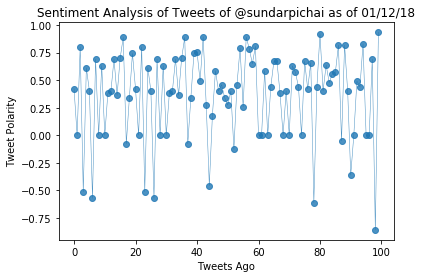

Tweeted the Analysis successfully!
Analyzing the tweets of @tim_cook
tweet id 952014211965530113


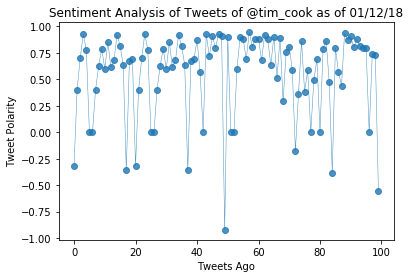

Tweeted the Analysis successfully!
Analyzing the tweets of @satyanadella
tweet id 952015471481532416


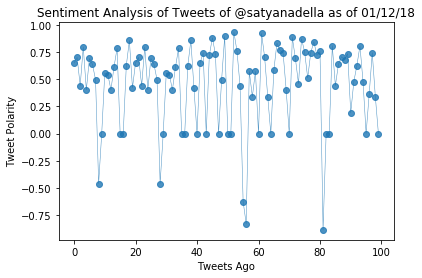

Tweeted the Analysis successfully!


In [8]:
# check for new tweets every 5 minutes
counter = 0

while True:
    try:
        target_user, tweet_id = getTargetUserInfo()
        if(target_user != "" and tweet_id != ""):
            print("Analyzing the tweets of " +target_user)
            print("tweet id " + str(tweet_id))
            tweets_info_df = performVaderAnalysis(target_user)
            createPlotAndRespond(tweets_info_df, tweet_id, target_user)
        
        counter = counter + 1
        time.sleep(5*60)

        if counter == 3:
            break
    except tweepy.TweepError as e:
        print("Exception :" +e.reason)